In [640]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 100)  

In [641]:
def prep_df(df):
    df[['service_date', "service_checkin", 'service_checkout']] = df[['service_date', "service_checkin", 'service_checkout']].astype('datetime64[ns]')
    df['service_people_cnt'] = df['service_people_cnt'] - df['service_child_cnt']
    return df

def drop_columns(df, columns_to_drop):
    for column in columns_to_drop:
        df = df.drop(column, axis=1)
    return df


In [642]:
train_df = pd.read_csv('data/train.csv', index_col='service_id')
test_df = pd.read_csv('data/public_test.csv', index_col='service_id')

train_df = train_df.drop_duplicates()
train_df = train_df.dropna()
train_df = prep_df(train_df)
test_df = prep_df(test_df)



In [643]:
numerical_cols = test_df.select_dtypes(include=['int', 'float']).columns
categorical_cols = test_df.select_dtypes(include='O').columns
target = 'service_status'

In [644]:
date_columns = ['service_date', "service_checkin", 'service_checkout']

## EDA

In [645]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2461285 entries, 12528139 to 31793047
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   service_date        datetime64[ns]
 1   service_checkin     datetime64[ns]
 2   service_checkout    datetime64[ns]
 3   service_price       float64       
 4   service_child_cnt   float64       
 5   service_people_cnt  float64       
 6   client_id           int64         
 7   client_segment      object        
 8   hotel_id            int64         
 9   country_name        object        
 10  city_name           object        
 11  category_star       float64       
 12  hotel_type          object        
 13  hotel_seasonal      int64         
 14  room_category       int64         
 15  service_status      int64         
dtypes: datetime64[ns](3), float64(4), int64(5), object(4)
memory usage: 319.2+ MB


In [646]:
train_df.head()

,service_date,service_checkin,service_checkout,service_price,service_child_cnt,service_people_cnt,client_id,client_segment,hotel_id,country_name,city_name,category_star,hotel_type,hotel_seasonal,room_category,service_status
service_id,,,,,,,,,,,,,,,,
12528139,2016-12-28,2017-01-16,2017-01-17,2395.80,0.0,1.0,210509,b2b2c,7695,Россия,Реутов,0.0,hotel,0,20,1
12528148,2016-12-28,2017-01-19,2017-01-23,10062.36,0.0,2.0,210509,b2b2c,36934,Россия,Санкт-Петербург,3.0,mini-hotel,0,50,0
12528157,2016-12-28,2016-12-31,2017-01-01,2332.00,0.0,2.0,213592,b2b2c,7107,Россия,Биробиджан,3.0,hotel,0,30,0
12528166,2016-12-28,2016-12-29,2016-12-30,2259.92,0.0,1.0,224181,b2bBusinessTravel,3966,Россия,Владивосток,0.0,hotel,0,30,0
12528175,2016-12-28,2016-12-30,2016-12-31,1400.00,0.0,1.0,224181,b2bBusinessTravel,427,Россия,Москва,3.0,hotel,0,30,0


In [647]:
train_df[target].value_counts(normalize=True)

service_status
0    0.857537
1    0.142463
Name: proportion, dtype: float64

### Numerical

In [648]:
train_df[numerical_cols].describe().apply(lambda x: np.round(x, 3)).T

,count,mean,std,min,25%,50%,75%,max
service_price,2461285.0,9499.889,13514.086,-90.0,3200.0,5656.0,11035.94,1976845.5
service_child_cnt,2461285.0,0.090,0.468,0.0,0.0,0.0,0.00,8.0
service_people_cnt,2461285.0,1.765,0.904,1.0,1.0,2.0,2.00,10.0
client_id,2461285.0,283464.796,161814.804,202601.0,213592.0,248088.0,291090.00,1183833.0
hotel_id,2461285.0,40782.650,70021.701,7.0,3760.0,10266.0,40479.00,419311.0
category_star,2461285.0,2.451,1.603,0.0,0.0,3.0,4.00,5.0
hotel_seasonal,2461285.0,0.009,0.096,0.0,0.0,0.0,0.00,1.0
room_category,2461285.0,36.547,17.618,10.0,30.0,30.0,40.00,120.0


In [649]:
train_df = train_df[train_df['service_price'] >= 0] # уберем брони, где цена меньше 0, это выброс


In [650]:
train_df.loc[train_df[target] == 0, numerical_cols].describe().apply(lambda x: np.round(x, 3)).T


,count,mean,std,min,25%,50%,75%,max
service_price,2110643.0,8949.846,11797.446,0.0,3151.0,5487.0,10561.0,1976845.5
service_child_cnt,2110643.0,0.074,0.423,0.0,0.0,0.0,0.0,8.0
service_people_cnt,2110643.0,1.733,0.884,1.0,1.0,2.0,2.0,10.0
client_id,2110643.0,277629.043,153244.498,202601.0,213592.0,239952.0,291090.0,1183823.0
hotel_id,2110643.0,39075.926,68121.317,7.0,3661.0,10022.0,36303.0,419311.0
category_star,2110643.0,2.468,1.592,0.0,0.0,3.0,4.0,5.0
hotel_seasonal,2110643.0,0.008,0.088,0.0,0.0,0.0,0.0,1.0
room_category,2110643.0,36.371,17.313,10.0,30.0,30.0,40.0,120.0


In [651]:
train_df.loc[train_df[target] == 1, numerical_cols].describe().apply(lambda x: np.round(x, 3)).T

,count,mean,std,min,25%,50%,75%,max
service_price,350641.0,12810.837,20770.059,0.0,3584.0,7000.0,14400.0,1545600.0
service_child_cnt,350641.0,0.190,0.667,0.0,0.0,0.0,0.0,8.0
service_people_cnt,350641.0,1.954,0.995,1.0,1.0,2.0,2.0,8.0
client_id,350641.0,318592.464,202480.947,202601.0,229449.0,275640.0,291090.0,1183833.0
hotel_id,350641.0,51055.192,79749.437,7.0,4621.0,12359.0,64938.0,418856.0
category_star,350641.0,2.351,1.666,0.0,0.0,3.0,4.0,5.0
hotel_seasonal,350641.0,0.019,0.135,0.0,0.0,0.0,0.0,1.0
room_category,350641.0,37.606,19.318,10.0,30.0,30.0,40.0,120.0


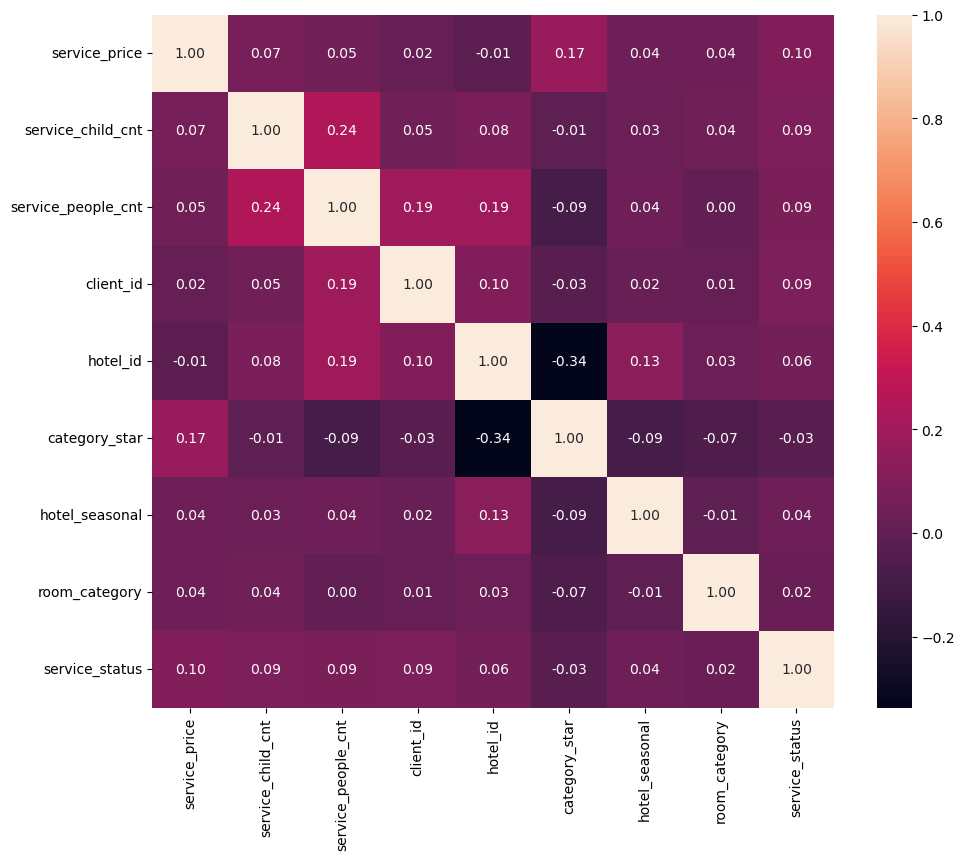

In [652]:
corr_matrix = train_df.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix,annot=True, fmt=".2f")

plt.show()

### Categorical

In [653]:
for col in categorical_cols:
    display(train_df.loc[train_df[target] == 1, col].value_counts(normalize=True) * 100)
    display(train_df.loc[train_df[target] == 0, col].value_counts(normalize=True) * 100)
    

client_segment
b2b2c                58.466922
b2bBusinessTravel    30.323893
b2c                   7.551884
b2bTravelAgencies     2.786040
b2bTourOperators      0.538157
b2g                   0.310859
corporateClient       0.022245
Name: proportion, dtype: float64

client_segment
b2bBusinessTravel    53.998094
b2b2c                37.464555
b2bTravelAgencies     4.848949
b2c                   2.481329
b2bTourOperators      0.606261
b2g                   0.551917
corporateClient       0.048895
Name: proportion, dtype: float64

country_name
Россия          95.738947
Беларусь         2.721587
Казахстан        0.447181
Узбекистан       0.364761
Абхазия          0.339664
Кыргызстан       0.152293
Армения          0.136037
Таджикистан      0.035649
Украина          0.023386
Грузия           0.013974
Южная Осетия     0.012834
Азербайджан      0.012263
Молдавия         0.000570
Туркменистан     0.000570
Египет           0.000285
Name: proportion, dtype: float64

country_name
Россия          97.091408
Беларусь         1.837450
Казахстан        0.422431
Узбекистан       0.254093
Абхазия          0.134793
Кыргызстан       0.123754
Армения          0.086656
Таджикистан      0.019947
Украина          0.009855
Грузия           0.007581
Южная Осетия     0.006491
Азербайджан      0.004643
Египет           0.000569
Молдавия         0.000190
Туркменистан     0.000095
Эстония          0.000047
Name: proportion, dtype: float64

city_name
Москва              11.825485
Санкт-Петербург      8.477046
Казань               3.476775
Минск                2.142362
Сочи                 1.929894
                      ...    
Пигаревский          0.000285
Октябрьское пос.     0.000285
Каргополье           0.000285
Емва                 0.000285
Веселовка            0.000285
Name: proportion, Length: 2281, dtype: float64

city_name
Москва              11.312761
Санкт-Петербург      7.188662
Казань               2.358049
Екатеринбург         1.842519
Нижний Новгород      1.661579
                      ...    
Трудовой поселок     0.000047
Льялово              0.000047
Ломово               0.000047
Червишево с.         0.000047
Глафировка           0.000047
Name: proportion, Length: 2691, dtype: float64

hotel_type
hotel                       70.531113
mini-hotel                  13.680659
hostel                       3.533243
guest-house                  3.394070
city-serviced-apartments     2.930062
aparthotel                   2.071064
furnished-rooms              1.258552
turbaza                      0.622004
resort-hotel                 0.549565
country-hotel                0.435488
health-resort                0.297455
pension                      0.193360
living-quarters              0.166552
capsule-hotel                0.127196
motel                        0.123773
cottage                      0.043064
glamping                     0.029660
villa                        0.010837
camping                      0.002282
Name: proportion, dtype: float64

hotel_type
hotel                       74.802608
mini-hotel                  14.091677
city-serviced-apartments     2.537521
guest-house                  2.400311
hostel                       2.174551
aparthotel                   1.696876
furnished-rooms              0.884186
turbaza                      0.345155
country-hotel                0.244238
resort-hotel                 0.216237
health-resort                0.142089
motel                        0.117358
living-quarters              0.115841
pension                      0.098927
capsule-hotel                0.094426
cottage                      0.019331
glamping                     0.015209
villa                        0.002653
camping                      0.000805
Name: proportion, dtype: float64

## Feature Engineering

Новые данные:
1. lead_time - Количество дней между бронированием и прибытием. (chekin - date)
2. checkin_date_year - год прибытия
3. checkin_date_month - месяц прибытия.
4. checkin_date_week - номер недели  года прибытия
5. checkin_date_day_of_month - день месяца прибытия
6. stays_in_week - Количество дней в неделю, которые гость прожил или забронировал
7. previous_cancel - Количество предыдущих бронирований, отмененных клиентом!!!
8. count_of_bookings - количество всех предыдущих бронирований
9. percent - доля отмененных броней

In [654]:
def process_df(df, previous_df=train_df, flag=True):
    df['lead_time'] = (df['service_checkin'] - df['service_date']).apply(lambda x: x.days)

    df['checkin_date_month'] = df['service_checkin'].apply(lambda x: x.month)
    df['checkin_date_year'] = df['service_checkin'].apply(lambda x: x.year)
    df['checkin_date_day_of_month'] = df['service_checkin'].apply(lambda x: x.day)
    df['checkin_date_week'] = df['service_checkin'].apply(lambda x: x.week)

    df['stays_in_week_day'] = (df['service_checkout'] - df['service_checkin']).apply(lambda x: x.days)
    if flag:      
        df['count_of_bookings'] = df.groupby(['client_id'])['service_date'].rank(method='first')
        previous_cancel_series = df.groupby(['client_id'])[target].expanding().sum().reset_index()[['service_id', 'service_status']].sort_values(by='service_id')
        df['previous_cancel'] = previous_cancel_series['service_status'].tolist()
    else:
        client_id_test = pd.DataFrame(df['client_id'].unique(), columns=['client_id'])
        client_id_test_previous = pd.merge(client_id_test, previous_df[['client_id', 'previous_cancel']], \
                    how='left', left_on='client_id', right_on='client_id').drop_duplicates().fillna(0)

        client_id_test_previous = client_id_test_previous.groupby('client_id').max().reset_index()
        df = pd.merge(df, client_id_test_previous, how='left', left_on='client_id', right_on='client_id')
        
        client_id_test = pd.DataFrame(df['client_id'].unique(), columns=['client_id'])
        client_id_test_previous = pd.merge(client_id_test, previous_df[['client_id', 'count_of_bookings']], \
                    how='left', left_on='client_id', right_on='client_id').drop_duplicates().fillna(0)

        client_id_test_previous = client_id_test_previous.groupby('client_id').max().reset_index()
        df = pd.merge(df, client_id_test_previous, how='left', left_on='client_id', right_on='client_id')
        
    
    df['percent'] = df['previous_cancel'] / df['count_of_bookings']
    
    df = df.drop(date_columns, axis=1)

    return df

## Modeling.

### CatBoost

In [655]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split,  cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier, Pool


In [656]:
def report_model(y_test, y_pred_class):
    conf_mat = confusion_matrix(y_test, y_pred_class)

    report = classification_report(y_test, y_pred_class)
    print("Отчет о классификации:")
    print(report)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, cmap="Blues")
    plt.xlabel("Предсказанные значения")
    plt.ylabel("Истинные значения")
    plt.title("Матрица ошибок")
    plt.show()

In [657]:
train_df_pred = train_df.copy()
test_df_pred = test_df.copy()
    

In [658]:
all_train = train_df_pred[:int(train_df_pred.shape[0] * 0.8)] # 0.8 - TOP
all_test = train_df_pred[int(train_df_pred.shape[0] * 0.8):]


In [ ]:
all_train = process_df(all_train, all_train)
all_test = process_df(all_test, all_train, False)


In [660]:
all_train = drop_columns(all_train, ['client_id', 'country_name', 'hotel_id', 'count_of_bookings']) # Удалим данные столбцы, потому что они нам не нужны
all_test = drop_columns(all_test, ['client_id', 'country_name', 'hotel_id', 'count_of_bookings'])


In [661]:
X_train = all_train.drop(target, axis=1)
X_test = all_test.drop(target, axis=1)
y_train = all_train[target]
y_test = all_test[target]

In [662]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1969027 entries, 12528139 to 28949770
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   service_price              float64
 1   service_child_cnt          float64
 2   service_people_cnt         float64
 3   client_segment             object 
 4   city_name                  object 
 5   category_star              float64
 6   hotel_type                 object 
 7   hotel_seasonal             int64  
 8   room_category              int64  
 9   lead_time                  int64  
 10  checkin_date_month         int64  
 11  checkin_date_year          int64  
 12  checkin_date_day_of_month  int64  
 13  checkin_date_week          int64  
 14  stays_in_week_day          int64  
 15  previous_cancel            float64
 16  percent                    float64
dtypes: float64(6), int64(8), object(3)
memory usage: 270.4+ MB


In [663]:
numerical_cols = X_test.select_dtypes(include=['int', 'float']).columns
categorical_cols = X_test.select_dtypes(include='O').columns
target = 'service_status'

In [664]:
model_cat = CatBoostClassifier(
    verbose=200,
    eval_metric='F1',
    auto_class_weights='SqrtBalanced',
    task_type='GPU',
    has_time=True,
    learning_rate=0.022212
)
#0.022212
train_pool = Pool(X_train, y_train, cat_features=np.array(categorical_cols))
model_cat.fit(train_pool)

test_pool = Pool(X_test, y_test, cat_features=np.array(categorical_cols))
y_preds = model_cat.predict(test_pool)
f1_macro = f1_score(y_test, y_preds, average='macro') 
print("F1-macro score:", f1_macro)

0:	learn: 0.5202896	total: 128ms	remaining: 2m 8s
200:	learn: 0.5388907	total: 26.2s	remaining: 1m 44s
400:	learn: 0.5469437	total: 50.7s	remaining: 1m 15s
600:	learn: 0.5506934	total: 1m 14s	remaining: 49.7s
800:	learn: 0.5527359	total: 1m 38s	remaining: 24.4s
999:	learn: 0.5538274	total: 2m 1s	remaining: 0us
F1-macro score: 0.6648337587381995


In [665]:
y_preds_train = model_cat.predict(train_pool)
f1_macro = f1_score(y_train, y_preds_train, average='macro')
print("F1-macro score:", f1_macro)

F1-macro score: 0.6911184043619361


In [666]:
y_preds = model_cat.predict(test_pool)
f1_macro = f1_score(y_test, y_preds, average='macro')
print("F1-macro score:", f1_macro)

F1-macro score: 0.6648337587381995


Отчет о классификации:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86    403635
           1       0.42      0.53      0.47     88622

    accuracy                           0.78    492257
   macro avg       0.65      0.68      0.66    492257
weighted avg       0.81      0.78      0.79    492257



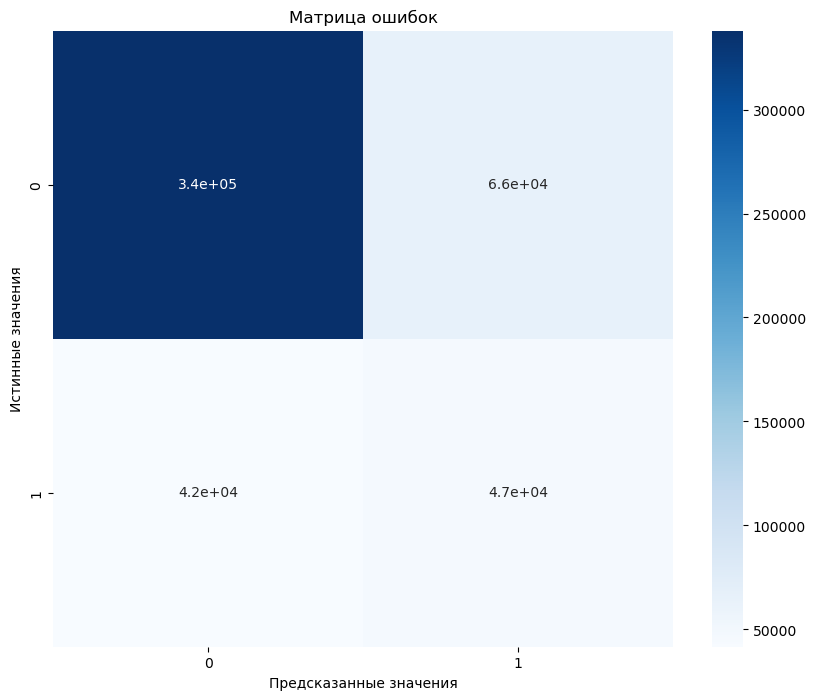

In [667]:
report_model(y_test, y_preds)

In [668]:
features = pd.DataFrame(model_cat.get_feature_importance(), index=X_test.columns, columns=['importance']).sort_values(by='importance', ascending=False)
features

,importance
percent,57.904735
lead_time,21.511211
client_segment,8.797004
previous_cancel,2.668631
service_price,1.613765
city_name,1.267319
service_people_cnt,1.233983
checkin_date_week,1.138253
stays_in_week_day,0.894096
hotel_type,0.767208


In [669]:
train_df_pred = process_df(train_df, train_df)
test_df = process_df(test_df, train_df_pred, False)
train_df_pred = drop_columns(train_df_pred, ['client_id', 'country_name', 'hotel_id', 'count_of_bookings'])
test_df = drop_columns(test_df, ['client_id', 'country_name', 'hotel_id', 'count_of_bookings'])

test_df['client_segment'] = test_df['client_segment'].fillna(test_df['client_segment'].mode()[0])
test_df['city_name'] = test_df['city_name'].fillna(test_df['city_name'].mode()[0])
test_df['category_star'] = test_df['category_star'].fillna(0)
test_df['percent'] = test_df['percent'].fillna(0)


In [670]:
test_pool_public = Pool(test_df, cat_features=np.array(categorical_cols))
y_preds_public = model_cat.predict(test_pool_public)

In [671]:
submission = pd.read_csv('data/sample_submission.csv')
submission['1'] = y_preds_public.astype("int8")
submission.to_csv("data/submission_С_good_people_80_all_lr_public.csv", index=False, header=None) 

In [672]:
private_df = pd.read_csv('data/private_test.csv', index_col='service_id')
private_df = prep_df(private_df)
private_df = process_df(private_df, train_df, False)

private_df = drop_columns(private_df, ['client_id', 'country_name', 'hotel_id', 'count_of_bookings'])


In [673]:
private_df['client_segment'] = private_df['client_segment'].fillna(private_df['client_segment'].mode()[0])
private_df['city_name'] = private_df['city_name'].fillna(private_df['city_name'].mode()[0])
private_df['category_star'] = private_df['category_star'].fillna(0)

private_df['percent'] = private_df['percent'].fillna(0)


In [674]:
test_pool_private = Pool(private_df, cat_features=np.array(categorical_cols))
y_preds_private = model_cat.predict(test_pool_private)

In [675]:
submission = pd.read_csv('data/sample_submission.csv')
submission['1'] = y_preds_private.astype("int8")
submission.to_csv("data/submission_С_private.csv", index=False, header=None) 